# Tutorial 2: Restoring a Noisy ECG with a Physics-Aware AI

In the real world, especially with portable sensors, ECG signals rarely look as clean as the one in our first tutorial. They often get corrupted by "noise."

### Common Types of Noise:
*   **Muscle Artifact (EMG):** Fuzzy, chaotic noise from muscle movement.
*   **Baseline Wander:** Slow drifting of the signal up and down, often from breathing.
*   **Electrode Motion:** Sharp, sudden spikes when a sensor loses contact.

This noise can hide or mimic real heart problems, making diagnosis difficult. In this notebook, we will intentionally add severe noise to a clean signal and then use our pretrained AI denoiser to see if it can restore it.

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

# --- Set up our project environment ---
# Change the working directory to the project root for easy imports and pathing
if os.path.basename(os.getcwd()) == 'tutorials':
    os.chdir('..')
print(f"Current working directory set to: {os.getcwd()}")

# --- Import our custom project functions ---
from src.data_utils import load_and_resample_signal, get_noise_signals, create_noisy_clean_pair, TARGET_FS
from src.inference import load_model, denoise_ecg_signal, DEVICE

# --- Configuration ---
CLEAN_RECORD_NAME = '101'
NOISE_TYPE_TO_ADD = 'ma' # 'ma' for muscle artifact, 'bw' for baseline wander
SNR_DB = 3 # Signal-to-Noise Ratio in decibels. Lower is noisier.

# --- Load Clean Signal ---
print(f"Loading clean ECG record: {CLEAN_RECORD_NAME}...")
clean_record_path = os.path.join('data', 'mit-bih-arrhythmia-database-1.0.0', CLEAN_RECORD_NAME)
clean_signal = load_and_resample_signal(clean_record_path, TARGET_FS)

# --- Load Noise Signal ---
print(f"Loading '{NOISE_TYPE_TO_ADD}' noise...")
noise_data_path = os.path.join('data', 'mit-bih-noise-stress-test-database-1.0.0')
# Note: get_noise_signals returns a dictionary. The 'ma' noise is mapped to the key 'muscle_artifact'.
noise_signals = get_noise_signals(noise_data_path, TARGET_FS)
noise_to_add = noise_signals['muscle_artifact']

# --- Create a Noisy Signal ---
# We'll tile the noise to match the length of our clean signal
if len(noise_to_add) < len(clean_signal):
    repeats = int(np.ceil(len(clean_signal) / len(noise_to_add)))
    noise_to_add = np.tile(noise_to_add, repeats)
noise_to_add = noise_to_add[:len(clean_signal)]

# Adjust noise power to achieve the target SNR
power_clean = np.mean(clean_signal ** 2)
power_noise_initial = np.mean(noise_to_add ** 2)
scaling_factor = np.sqrt((power_clean / (10**(SNR_DB / 10))) / power_noise_initial)
scaled_noise = noise_to_add * scaling_factor

noisy_signal = clean_signal + scaled_noise
print(f"Successfully created a noisy signal with an SNR of {SNR_DB} dB.")

Current working directory set to: /Users/mohanarangandesigan/Developer/ecg-denoiser-hackathon
Loading clean ECG record: 101...
Loading 'ma' noise...
Successfully created a noisy signal with an SNR of 3 dB.


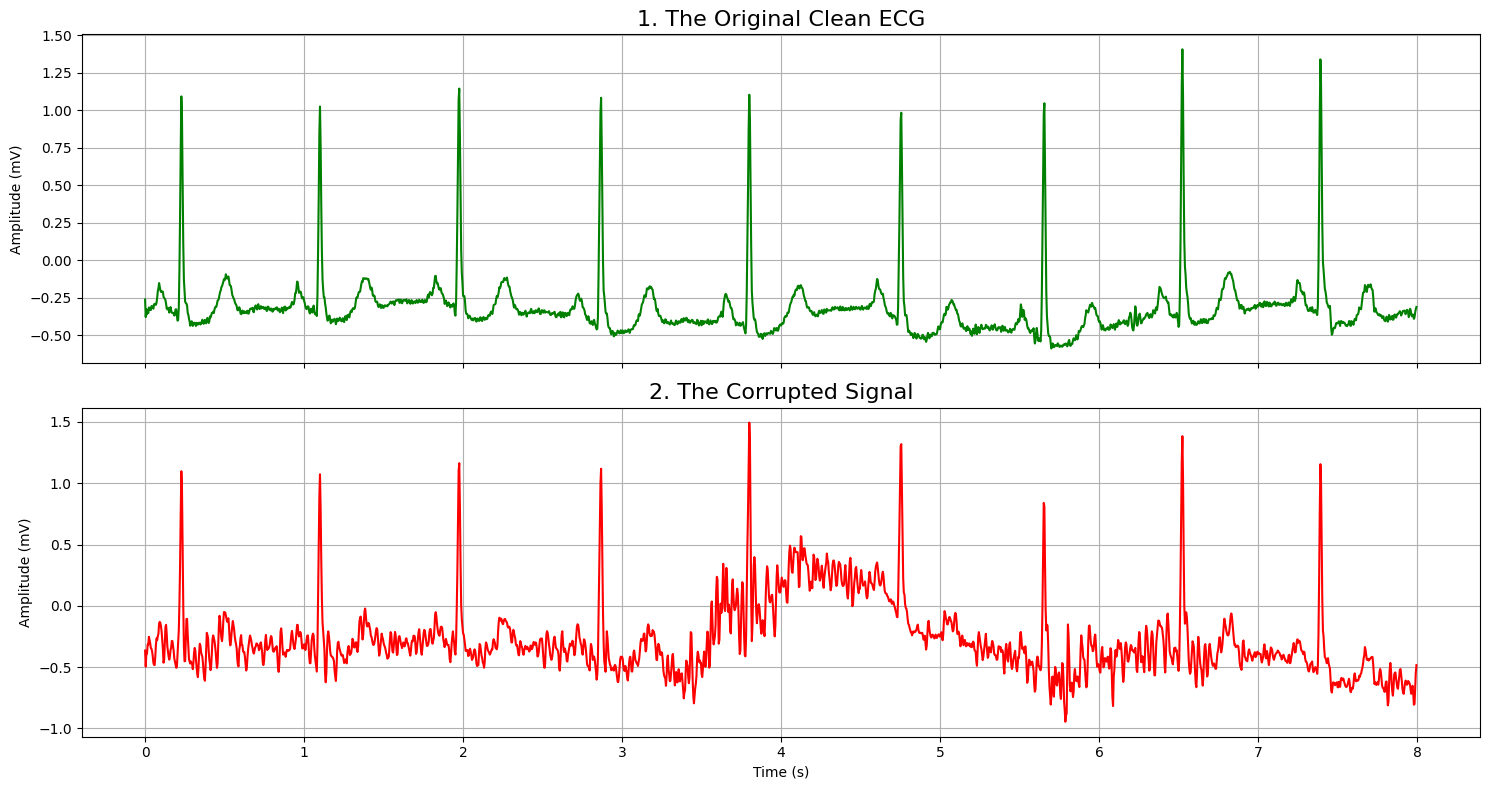

In [2]:
# --- Visualize the Problem ---
# Let's plot the first 8 seconds to see the damage
seconds_to_plot = 8
num_samples = int(seconds_to_plot * TARGET_FS)
time_axis = np.arange(num_samples) / TARGET_FS

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Plot Clean Signal
ax1.plot(time_axis, clean_signal[:num_samples], color='green', label='Original Clean Signal')
ax1.set_title('1. The Original Clean ECG', fontsize=16)
ax1.set_ylabel('Amplitude (mV)')
ax1.grid(True)

# Plot Noisy Signal
ax2.plot(time_axis, noisy_signal[:num_samples], color='red', label='Corrupted Noisy Signal')
ax2.set_title('2. The Corrupted Signal', fontsize=16)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude (mV)')
ax2.grid(True)

plt.tight_layout()
plt.show()

## Loading the AI Denoiser

The plot above clearly shows the problem. The noisy signal is messy, and the smaller P and T waves are almost completely hidden.

Now, let's load our pretrained AI denoiser. This is the U-Net model we trained for 50 epochs on thousands of examples just like this one.

In [3]:
# --- Load the Pretrained Denoiser Model ---
print("Loading the Physics-Aware Denoiser model...")
denoiser_model = load_model('models/ecg_denoiser_model.pth', DEVICE)

# --- Denoise the Signal ---
# We need to process the signal in 2048-sample chunks, just like during training.
print("Denoising the entire signal segment by segment...")
denoised_signal = np.zeros_like(noisy_signal)
for i in range(0, len(noisy_signal), 2048):
    segment = noisy_signal[i:i+2048]
    # Pad the last segment if it's too short
    if len(segment) < 2048:
        padded = np.zeros(2048)
        padded[:len(segment)] = segment
        segment = padded
    
    # Run the model
    denoised_segment = denoise_ecg_signal(segment, denoiser_model)
    
    # Place the denoised segment back into our full-length signal
    denoised_signal[i:i+2048] = denoised_segment[:len(noisy_signal[i:i+2048])]

print("✅ Denoising complete!")

Loading the Physics-Aware Denoiser model...
Model loaded from models/ecg_denoiser_model.pth and moved to cpu.
Denoising the entire signal segment by segment...
✅ Denoising complete!


Plotting the final comparison...


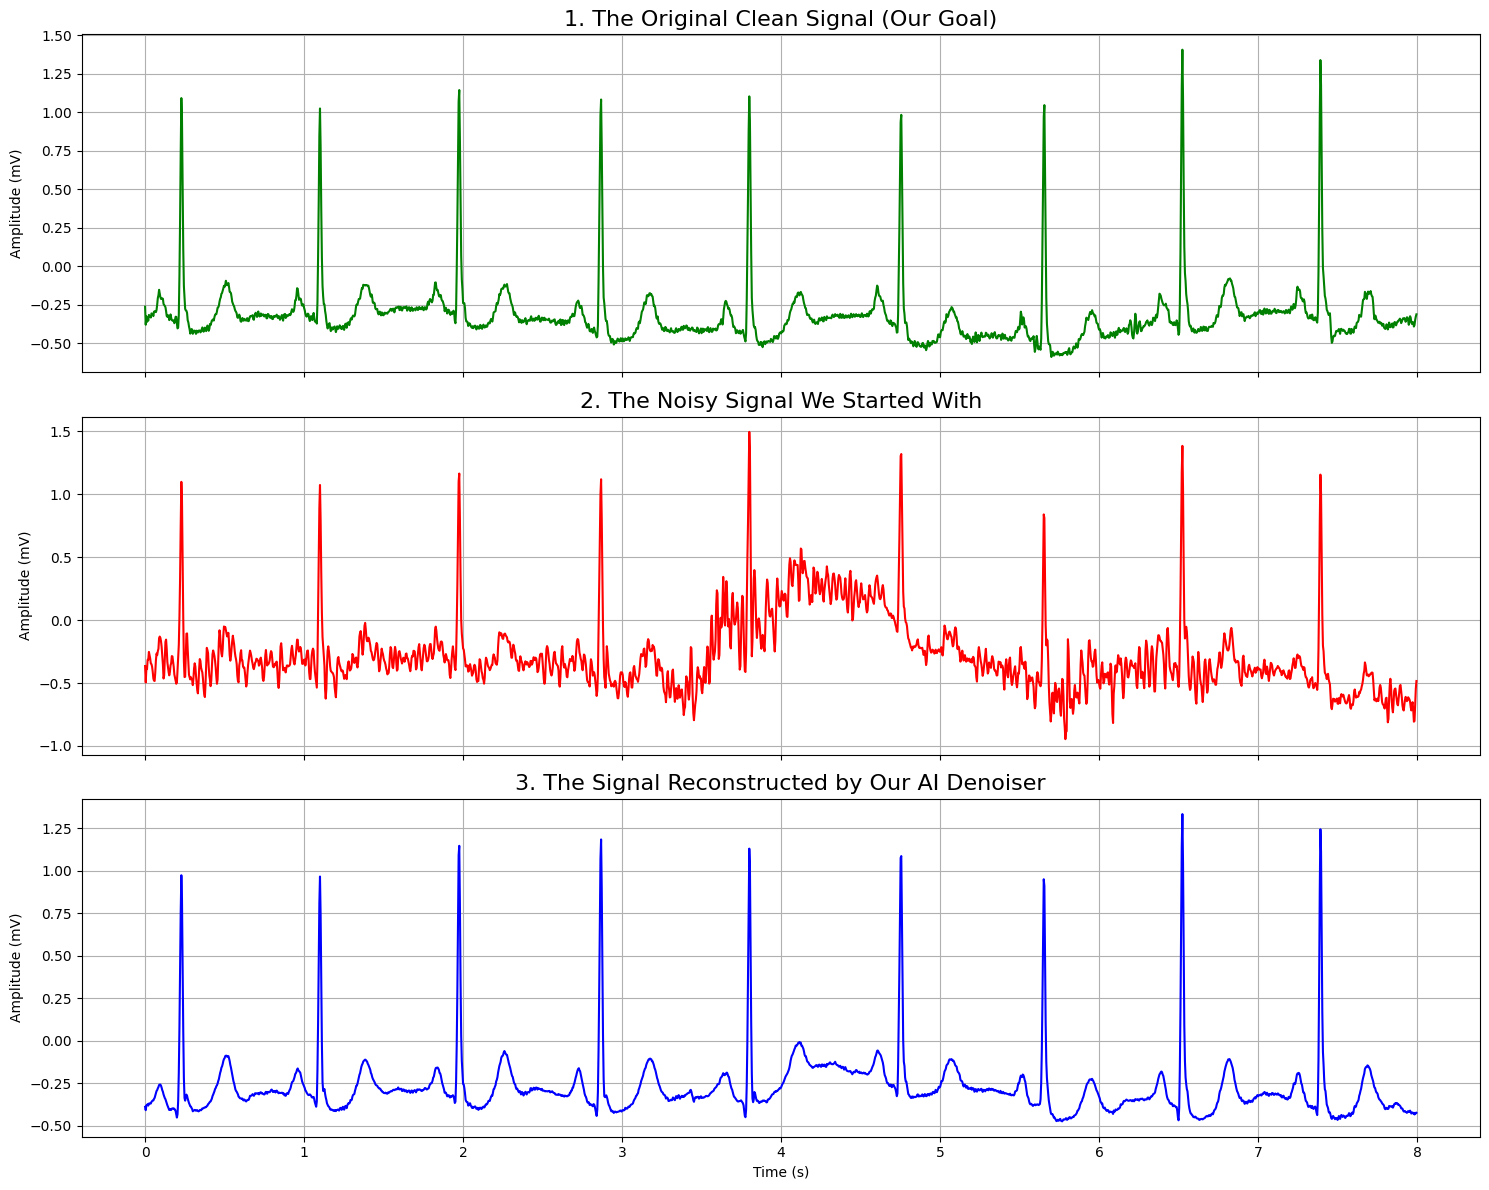

In [4]:
# --- The Grand Reveal: Plotting All Three Signals ---
print("Plotting the final comparison...")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Plot Clean Signal
ax1.plot(time_axis, clean_signal[:num_samples], color='green', label='Ground Truth')
ax1.set_title('1. The Original Clean Signal (Our Goal)', fontsize=16)
ax1.set_ylabel('Amplitude (mV)')
ax1.grid(True)

# Plot Noisy Signal
ax2.plot(time_axis, noisy_signal[:num_samples], color='red', label='Corrupted Input')
ax2.set_title('2. The Noisy Signal We Started With', fontsize=16)
ax2.set_ylabel('Amplitude (mV)')
ax2.grid(True)

# Plot Denoised Signal
ax3.plot(time_axis, denoised_signal[:num_samples], color='blue', label='AI Output')
ax3.set_title('3. The Signal Reconstructed by Our AI Denoiser', fontsize=16)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Amplitude (mV)')
ax3.grid(True)

plt.tight_layout()
plt.show()

## Analysis of the Result

Look at the final plot. The **AI Denoised** signal is incredibly close to the **Original Clean** signal. Our model successfully:
-   Flattened the noisy baseline.
-   Removed the chaotic, high-frequency muscle noise.
-   **Crucially, it preserved the sharp, tall QRS complexes and the shapes of the T-waves.**

This demonstrates the power of our physics-aware approach. The model didn't just apply a simple filter; it learned the fundamental structure of a heartbeat and used that knowledge to reconstruct it from a corrupted source.

---

## Playground: Try Other Types of Noise!

Below is a function that adds **baseline wander** (a slow drift). Try running it! How well does the denoiser handle it? Can you combine both muscle noise *and* baseline wander?

Experiment by changing the parameters to see how the AI performs under different conditions.

Denoising the signal with both muscle noise and baseline wander...
Denoising complete!


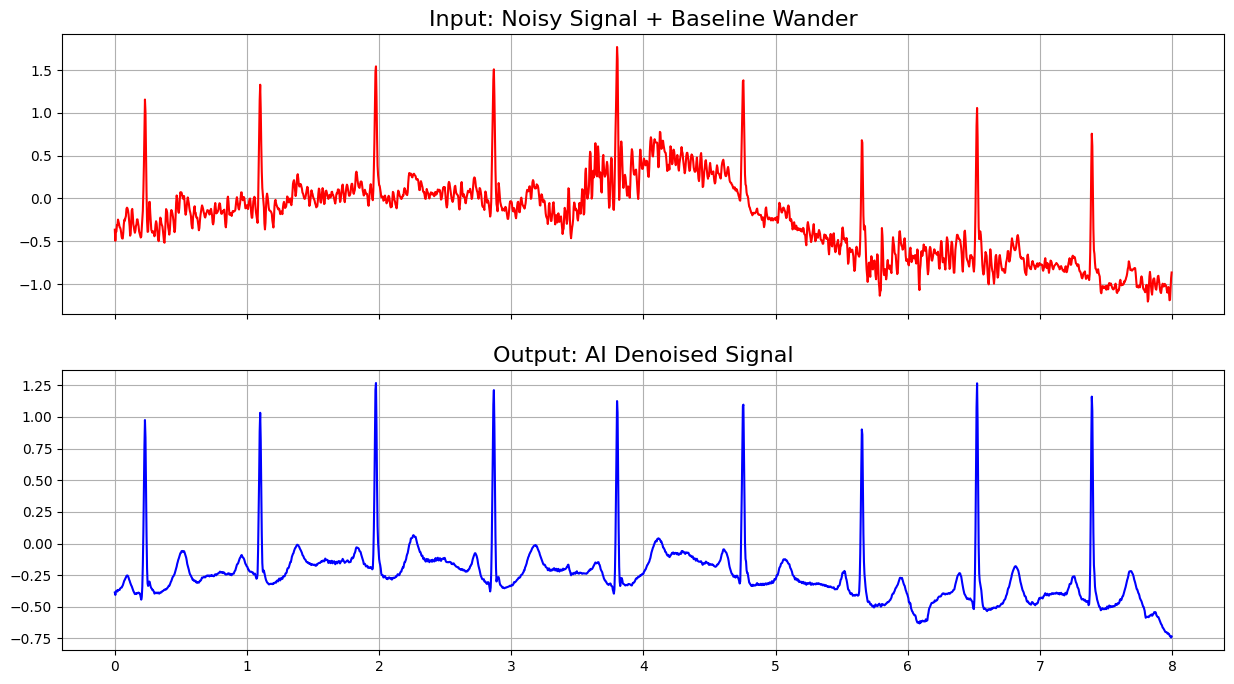

In [5]:
# --- Playground Cell ---

def add_baseline_wander(signal, amp=0.3, freq=0.2, fs=250):
    """A function to add a slow sine wave to simulate baseline wander."""
    t = np.arange(len(signal)) / fs
    drift = amp * np.sin(2 * np.pi * freq * t)
    return signal + drift

# --- TRY IT YOURSELF! ---
# 1. Create a noisy signal (or use the one from before)
noisy_signal_playground = clean_signal + scaled_noise 

# 2. Add baseline wander to it
noisy_with_drift = add_baseline_wander(noisy_signal_playground, amp=0.4, freq=0.1)

# 3. Denoise the new signal
print("Denoising the signal with both muscle noise and baseline wander...")
denoised_drift_signal = np.zeros_like(noisy_with_drift)
for i in range(0, len(noisy_with_drift), 2048):
    segment = noisy_with_drift[i:i+2048]
    if len(segment) < 2048:
        padded = np.zeros(2048); padded[:len(segment)] = segment; segment = padded
    denoised_segment = denoise_ecg_signal(segment, denoiser_model)
    denoised_drift_signal[i:i+2048] = denoised_segment[:len(noisy_with_drift[i:i+2048])]
print("Denoising complete!")


# 4. Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
ax1.plot(time_axis, noisy_with_drift[:num_samples], color='red')
ax1.set_title('Input: Noisy Signal + Baseline Wander', fontsize=16)
ax1.grid(True)
ax2.plot(time_axis, denoised_drift_signal[:num_samples], color='blue')
ax2.set_title('Output: AI Denoised Signal', fontsize=16)
ax2.grid(True)
plt.show()